# "Introduction to Anomaly Detection in Python"




In [0]:
# Import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Shpw the plots in your Jupyter Notebook
#%matplotlib inline
# Use a predefined style set
plt.style.use('ggplot')

Let's first create a dummy dataset for ourselves. The dataset will contain just two columns - 
- Name of the employees.
- Salaries of those employees (in USD) within a range of 1000 to 2500.

For generating the names we will use a Python library called `Faker`.

In [10]:
!pip install faker
from faker import Faker
fake = Faker()

# To ensure the results are reproducible
Faker.seed(4321)

names_list = []

fake = Faker()
for _ in range(100):
  names_list.append(fake.name())

# Verify if 100 names were generated
len(names_list)

100

In [11]:
# To ensure the results are reproducible
np.random.seed(7)

salaries = []
for _ in range(100):
    salary = np.random.randint(1000,2500)
    salaries.append(salary)

    # Verify if 100 salariy values were generated
len(salaries)

100

In [14]:
# Create pandas DataFrame
salary_df = pd.DataFrame(
    {'Person': names_list,
     'Salary (in USD)': salaries
    })

# Print a subsection of the DataFrame
salary_df.head()

,Person,Salary (in USD)
0,Jason Brown,1175
1,Jacob Stein,2220
2,Cody Brown,1537
3,Larry Morales,1502
4,Jessica Hendricks,1211


Let's now manually change the salary entries of two individuals. In reality, this can actually happen for a number of reasons such as the data recording software may have got corrupted at the time of recording the respective data.

In [0]:
salary_df.at[16, 'Salary (in USD)'] = 23
salary_df.at[65, 'Salary (in USD)'] = 17

In [16]:
# Verify if the salaries were changed
print(salary_df.loc[16])
print(salary_df.loc[65])

Person             Miss Amanda Harris MD
Salary (in USD)                       23
Name: 16, dtype: object
Person             Joyce Bishop
Salary (in USD)              17
Name: 65, dtype: object


### Boxplots

The generation of anomalies within data directly depends on the generation of the data points itself. Some basic statistics (like minimum value, maximum value, 1st quartile values etc.) in the form of a boxplot. 

![](https://pro.arcgis.com/en/pro-app/help/analysis/geoprocessing/charts/GUID-0E2C3730-C535-40CD-8152-80D794A996A7-web.png)

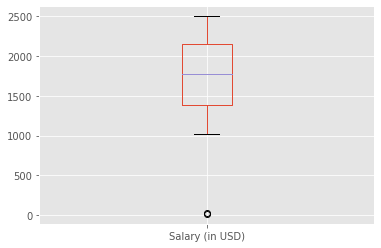

In [17]:
salary_df['Salary (in USD)'].plot(kind='box')
plt.show()

Notice the tiny circle point in the bottom. You instantly get a feeling of something wrong in there as _it deviates hugely from the rest of the data.

### Histograms 

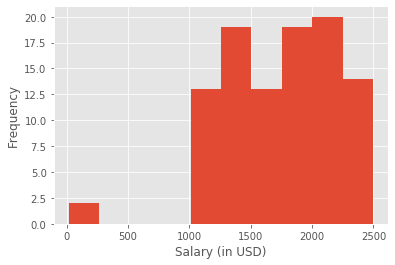

In [20]:
ax = salary_df['Salary (in USD)'].plot(kind='hist')
ax.set_xlabel('Salary (in USD)')
plt.show()

In the above histogram plot also, we can see there's one particular bin that is just not right as it deviates hugely from the rest of the data. We can also infer that there are only two employees for which the salaries seem to be distorted. 

Let's take a look at the minimum and maximum values of the column `Salary (in USD)`.  

In [21]:
print('Minimum salary ' + str(salary_df['Salary (in USD)'].min()))
print('Maximum salary ' + str(salary_df['Salary (in USD)'].max()))

Minimum salary 17
Maximum salary 2498


Look at the **minimum value**. From the accounts department of this hypothetical organization, you got to know that the minimum salary of an employee there is $1000. But you found out something different. Hence, its worth enough to conclude that this is indeed an anomaly. 

## Clustering based approach for anomaly detection

Clustering can be used for anomaly detection. Euclidean distance is a very popular choice when choosing in between several distance measurement functions. Let's take a look at what Euclidean distance is all about. 

### Euclidean distance

If there are n points on a two-dimensional space(refer the following figure) and their coordinates are denoted by(x_i, y_i), then the Euclidean distance between any two points((x1, y1) and(x2, y2)) on this space is given by:

$$
\sqrt{\left(x_{1}-x_{2}\right)^{2}+\left(y_{1}-y_{2}\right)^{2}}
$$

We are going to use [K-Means clustering] which will help us cluster the data points (salary values in our case). The implementation that we are going to be using for `KMeans` uses Euclidean distance internally.

In [0]:
# Convert the salary values to a numpy array
salary_raw = salary_df['Salary (in USD)'].values

# For compatibility with the SciPy implementation
salary_raw = np.reshape(-1, 1)   # Adding Dimension
salary_raw = salary_raw.astype('float64') # Casting to float64

We will now import the `kmeans` module from `scipy.cluster.vq`. SciPy stands for Scientific Python.

In [0]:
from scipy.cluster.vq import kmeans

# Supply the data and the number of clusters to kmeans()
codebook, distortion = kmeans(salary_raw, 4)

In the above chunk of code, we fed the salary data points the `kmeans()`. We also specified the number of clusters to which we want to group the data points. `cookbook` is the centroids generated by `kmeans()` and `distortion` is the averagedEuclidean distance between the data points fed and the centroids generated by `kmeans()`. 

Let's assign the groups of the data points by calling th `vq()` method. It takes - 
- The data points
- The centroid as generated by the clustering algorithm (`kmeans()` in our case)

It then returns the groups of the data points and the distance between the observation and its nearest group.

In [0]:
groups, cdist = cluster.vq.vq(salary_raw, codebook)

Let's now plot the groups we have got. 

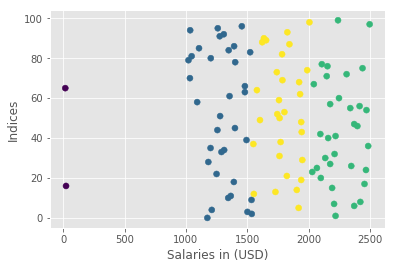

In [0]:
plt.scatter(salary_raw, np.arange(0,100), c=groups)
plt.xlabel('Salaries in (USD)')
plt.ylabel('Indices')
plt.show()

Can you point to the anomalies?

The above method for anomaly detection is purely [unsupervised] in nature. If we had the class-labels of the data points, we could have easily converted this to a [supervised learning] problem, specifically a _classification_ problem. 

## Anomaly detection as a classification problem

To be able to treat the task of anomaly detection as classification task, we need a labeled dataset. Let's give our existing dataset some labels. 

We will first assign all the entries to the class of 0 and then we will manually edit the labels for those two anomalies. 

In [39]:
# First assign all the instances to 
salary_df['class'] = 0

# Manually edit the labels for the anomalies
salary_df.at[16, 'class'] = 1
salary_df.at[65, 'class'] = 1

# Veirfy 
salary_df.loc[16]

Person             Miss Amanda Harris MD
Salary (in USD)                       23
class                                  1
Name: 16, dtype: object

Let's take a look at the dataset again.

In [40]:
salary_df.head()

,Person,Salary (in USD),class
0,Jason Brown,1175,0
1,Jacob Stein,2220,0
2,Cody Brown,1537,0
3,Larry Morales,1502,0
4,Jessica Hendricks,1211,0


We now have a binary classification task. We are going to use **proximity-based anomaly detection** for solving this task.

We are going to use the [k-NN classification method] for this. Also, we are going to use a Python library called `PyOD` which is specifically developed for anomaly detection purposes.

In [42]:
!pip install pyod
# Importing KNN module from PyOD
from pyod.models.knn import KNN

     |████████████████████████████████| 92kB 2.9MB/s 
  Created wheel for pyod: filename=pyod-0.7.7.1-cp36-none-any.whl size=98962 sha256=53d72ea72b836cda916aa9bc2c49f65730f4d161ea1c0a71ae12b1ab20229318
  Stored in directory: /root/.cache/pip/wheels/9c/9e/bc/5bac69bdb00bfefbbfa74a43409d328962c349ad1b0954470a
  Created wheel for combo: filename=combo-0.0.8-cp36-none-any.whl size=41508 sha256=4d2e0b051660abefb19893477507101bbe039d3435a3daedb54108ff4cfa3f65
  Stored in directory: /root/.cache/pip/wheels/dc/60/47/7b9c8b8e5561f6a51ccb7b0da69de7ae6af3a407e45e1e016f
  Created wheel for suod: filename=suod-0.0.0-cp36-none-any.whl size=8657 sha256=8bfe0e5080d9143bbeb86bcb8c5e83d6c529751b1998387800813ac2289ebbaa
  Stored in directory: /root/.cache/pip/wheels/6c/42/2a/6a43a4ccfd1ad1f073d4ca300d0deade4649120d3d166a2d32
Successfully built pyod combo suod


The column `Person` is not at all useful for the model as it is nothing but a kind of identifier. Let's prepare the training data accordingly.  

In [0]:
# Separate the salary values and the class labels 
X = salary_df['Salary (in USD)'].values.reshape(-1,1)
y = salary_df['class'].values

In [44]:
# Train kNN
clf = KNN(contamination=0.02, n_neighbors=5)
clf.fit(X)

KNN(algorithm='auto', contamination=0.02, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

Let's discuss the two parameters we passed in to `KNN()` - 

- contamination - the amount of anomalies in the data (in percentage) which for our case is 2/100 = 0.02
- n_neighbors - number of neighbors to consider for measuring the proximity 

In [0]:
# Get the prediction labels of the training data
y_train_pred = clf.labels_ 

# Outlier scores
y_train_scores = clf.decision_scores_  

Let's now try to evaluate `KNN()` with respect to the training data. 

In [46]:
from pyod.utils import evaluate_print

# Evaluate on the training data
evaluate_print('KNN', y, y_train_scores)

KNN ROC:1.0, precision @ rank n:1.0


We see that the `KNN()` model was able perform exceptionally good on the training data. It provides three metrics and their scores - 
- [ROC]
- [Precision]
- A confidence rank with which it gives the outlier scores. 

We don't have any test data. But we can generate a sample salary value right? 

In [0]:
# A salary of $37 (an anomaly right?)
X_test = np.array([[37.]])

Let's now test how if the model could detect this salary value as an anomaly or not.

In [48]:
# Check what the model predicts on the given test data point
clf.predict(X_test)

array([1])

We can see the model predicts just right.

In [49]:
# A salary of $1256
X_test_abnormal = np.array([[1256.]])

# Predict
clf.predict(X_test_abnormal)

array([0])

The model predicted this one as the normal data point which is correct. 